BloomTech Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- If you haven't completed assignment #1, please do so first.
- Continue to clean and explore your data. Make exploratory visualizations.
- Fit a model. Does it beat your baseline? 
- Try xgboost.
- Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

Your code starts here:

## Business Scenario

Lending Club is an American peer-to-peer lending marketplace that connects investors with borrowers. Instead of a bank or financial institution, investors act as lenders to fund borrowers loans.

Investors want to lend money to people who show a profile 
of having a high probability of repayment. However, they face the challenge of predicting the risk of a borrower being unable to pay the loan back in full. They feel that the insights from existing data will help them in making data-driven decisions. So as data scientists, we will be building a model that can help in predicting whether a loan will not be repaid.

The dataset contains more than 9,500 loans with information about the borrower profile, loan structure and whether the loan was repaid. This data was extracted from [Kaggle - Loan Data](https://www.kaggle.com/datasets/itssuru/loan-data). 

### Updated data dictionary (Includes feature engineered columns)

|    | Variable          | Explanation                                                                                                             |
|---:|:------------------|:------------------------------------------------------------------------------------------------------------------------|
|  0 | credit_policy     | 1 if the customer meets the credit underwriting criteria; 0 otherwise.                                                  |
|  1 | purpose           | The purpose of the loan.                                                                                                |
|  2 | int_rate          | The interest rate of the loan (more risky borrowers are assigned higher interest rates).                                |
|  3 | installment       | The monthly installments owed by the borrower if the loan is funded.                                                    |
|  4 | log_annual_inc    | The natural log of the self-reported annual income of the borrower.                                                     |
|  5 | dti               | The debt-to-income ratio of the borrower (amount of debt divided by annual income).                                     |
|  6 | revol_bal              | The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).                           .                                                                                  |
|  7 | pub_rec           | The borrower's number of derogatory public records.                                                                  |
|  8 |  not_fully_paid    | 1 if the loan is not fully paid; 0 otherwise.                           |
|  9 | cred_score     | 1 if the customer credit score is preferred (over 670); 0 otherwise.  
| 10 | financially_responsible     | 1 if the customer hasn't missed more than 2 payments; 0 if the customer has missed more than 2 payments. 
| 11 | credit_hist     | 1 if the customer'scredit history is over 1096 days (3 years); 1 if the customer's credit history is longer than 3 years.                                                 |
| 12 | multiple_hard_inq    | 1 if the customer has multiple inquiries; 0 if the customer has none or only one inquiry.                            |
| 13 | cred_util_rate    | 1 if the customer uses less than 30% of the credit limit; 0 if the customer uses more than 30% of the credit limit or none of the credit limit.                                                                   |

In [1]:
# Import Libraries, Dataset

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from category_encoders import OrdinalEncoder, OneHotEncoder
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE, SMOTENC # to fix imbalance data
from imblearn.pipeline import make_pipeline as imblearn_pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.inspection import permutation_importance 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Path to dataset
DATA_PATH = '/Users/Yanin/Documents/BloomTech/Course/Sprint7/datasets/loan_data.csv'

## I. Wrangle Data

In [2]:
def wrangle(filepath):
    loans = pd.read_csv(filepath)
    
    # Replacing period in column names with underscore
    loans.columns = loans.columns.str.replace(".", "_")
    
    # Set data type of 'purpose' column as category
    loans['purpose'] = loans['purpose'].astype('category')
    
    # Outliers - Finding the upper and lower bounds for the log_annual_inc feature
    def find_outlier_limits(col_name):
        Q1,Q3=loans[col_name].quantile([.25,.75])
        IQR=Q3-Q1
        low=Q1-(1.5* IQR)
        high=Q3+(1.5* IQR)
        return (high,low)

    high_log_annual_inc, low_log_annual_inc = find_outlier_limits('log_annual_inc')

    # Replacing outlier values for log_annual_inc, and installment with respective upper and lower limits 
    loans.loc[loans['log_annual_inc'] > high_log_annual_inc,'log_annual_inc'] = high_log_annual_inc
    loans.loc[loans['log_annual_inc'] < low_log_annual_inc,'log_annual_inc'] = low_log_annual_inc
    
    # Feature Engineering
    loans['cred_score'] = loans['fico'].apply(lambda x: 0 if x < 670 else 1)
    loans['financially_responsible'] = loans['delinq_2yrs'].apply(lambda x: 0 if x > 2 else 1)
    loans['credit_hist'] = loans['days_with_cr_line'].apply(lambda x: 0 if x < 1096 else 1)
    loans['multiple_hard_inq'] = loans['inq_last_6mths'].apply(lambda x: 0 if x<=1 else 1)
    loans['cred_util_rate'] = loans['revol_util'].apply(lambda x: 1 if (x>30 or x==0) else 0)
    
    # To avoid data leakage let's drop the columns used to do feature engineering
    loans.drop(columns=['fico', 'delinq_2yrs', 'days_with_cr_line', 'inq_last_6mths', 'revol_util'], inplace=True)
    
    return loans

In [3]:
# Read loans data
loans = wrangle(DATA_PATH)

# Check shape of data set and first 5 rows
display(loans.shape)
loans.head()

(9578, 14)

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,revol_bal,pub_rec,not_fully_paid,cred_score,financially_responsible,credit_hist,multiple_hard_inq,cred_util_rate
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,28854,0,0,1,1,1,0,1
1,1,credit_card,0.1071,228.22,11.082143,14.29,33623,0,0,1,1,1,0,1
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,3511,0,0,1,1,1,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,33667,0,0,1,1,1,0,1
4,1,credit_card,0.1426,102.92,11.299732,14.97,4740,0,0,0,1,1,0,1


In [4]:
loans.isnull().sum().sum()

0

In [5]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   credit_policy            9578 non-null   int64   
 1   purpose                  9578 non-null   category
 2   int_rate                 9578 non-null   float64 
 3   installment              9578 non-null   float64 
 4   log_annual_inc           9578 non-null   float64 
 5   dti                      9578 non-null   float64 
 6   revol_bal                9578 non-null   int64   
 7   pub_rec                  9578 non-null   int64   
 8   not_fully_paid           9578 non-null   int64   
 9   cred_score               9578 non-null   int64   
 10  financially_responsible  9578 non-null   int64   
 11  credit_hist              9578 non-null   int64   
 12  multiple_hard_inq        9578 non-null   int64   
 13  cred_util_rate           9578 non-null   int64   
dtypes: categ

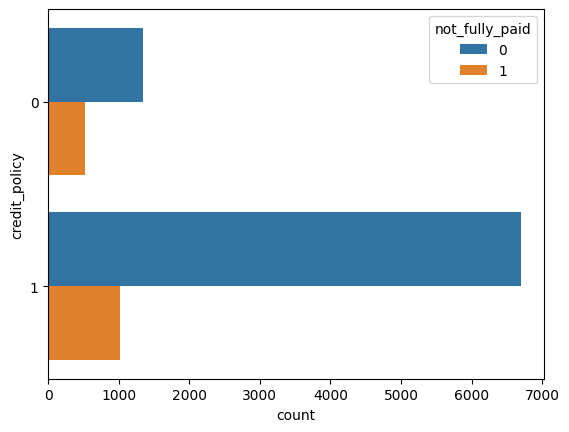

In [6]:
# From borrowers who didn't meet the underwriting criteria, how many were defaulters?
sns.countplot(data=loans, y='credit_policy', hue='not_fully_paid');

In [10]:
# Count of defaulters per credit_policy 
loans.groupby(['credit_policy', 'not_fully_paid'])['not_fully_paid'].count()

credit_policy  not_fully_paid
0              0                 1349
               1                  519
1              0                 6696
               1                 1014
Name: not_fully_paid, dtype: int64

In [11]:
# Percentage of defaulters per credit_policy 
loans.groupby('credit_policy')['not_fully_paid'].value_counts(normalize=True)

credit_policy  not_fully_paid
0              0                 0.722163
               1                 0.277837
1              0                 0.868482
               1                 0.131518
Name: not_fully_paid, dtype: float64

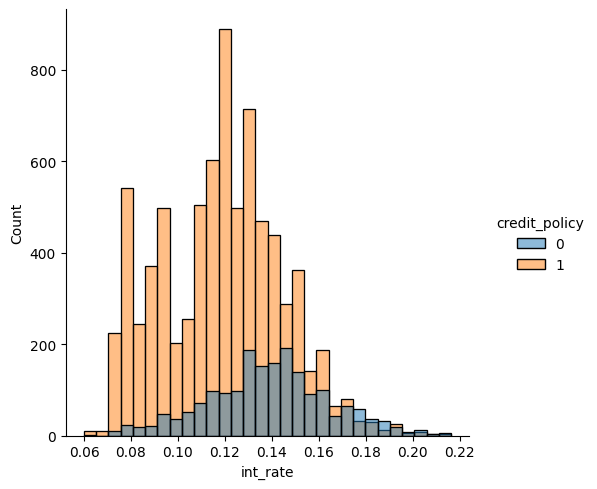

In [7]:
# Interest rate and credit policy distributions
sns.displot(data=loans, x='int_rate', bins = 30, hue = 'credit_policy', legend=True);

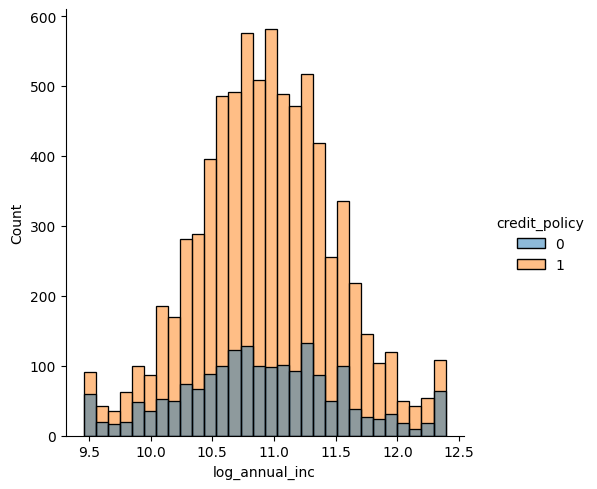

In [8]:
# Annual income and credit policy distributions
sns.displot(data=loans, x='log_annual_inc', bins = 30, hue = 'credit_policy', legend=True);

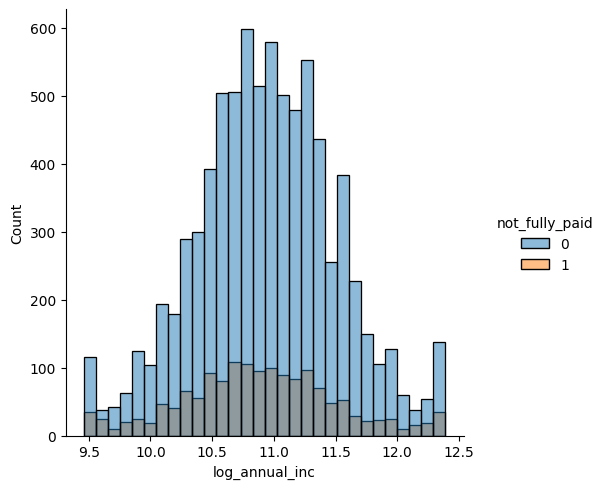

In [9]:
# Annual income and loan payment outcome distributions
sns.displot(data=loans, x='log_annual_inc', bins = 30, hue = 'not_fully_paid', legend=True);

In [12]:
# How many times was cred_score == 1 (preferred) in the dataset
preferred_cred_score = len([i for i in loans['cred_score'] if i == 1])
preferred_cred_score

8237

In [13]:
# Percentage of borrowers with preferred cred scores
prefer_cred_score_pt = (preferred_cred_score/len(loans)) * 100
print('% of borrowers with preferred credit score:', round(prefer_cred_score_pt))

% of borrowers with preferred credit score: 86


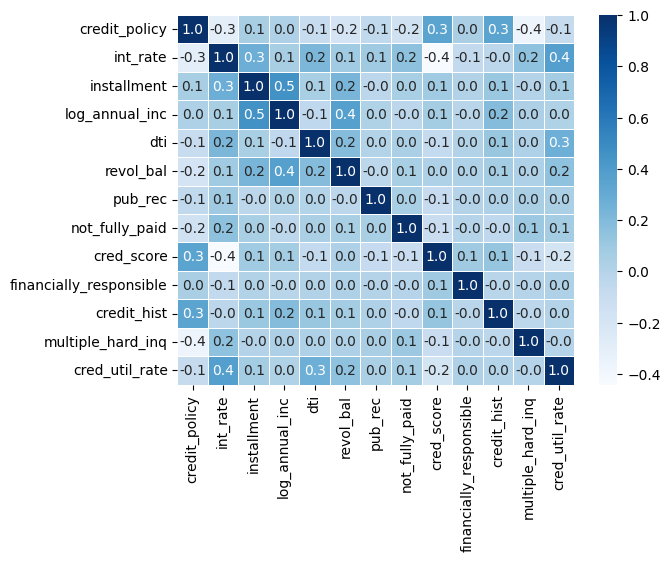

In [34]:
# Generate correlation matrix to understand the relationship between the different features
sns.heatmap(loans.corr(), annot=True,
            fmt=".1f", linewidth = 0.5, cmap = 'Blues');

## II. Split Data

In [14]:
# Split data into feature matrix and target vector
target = 'not_fully_paid'

y = loans[target] # target vector
X = loans.drop(columns=target) # feature matrix

In [15]:
# Randomly split data into remain and test sets
X_remain, X_test, y_remain, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [16]:
# Create a training set and validation set from the remaining data
X_train, X_val, y_train, y_val = train_test_split(X_remain, y_remain, test_size= 0.2, random_state = 42)

In [17]:
print('Baseline accuracy - imb data:', y_train.value_counts(normalize=True).max())

Baseline accuracy - imb data: 0.8350465002447381


## Build Model

In [19]:
# Balance the classes in the target vector
# method = SMOTE(random_state=42)
method = SMOTENC(random_state=42, categorical_features= [1,2])
X_train_bal, y_train_bal = method.fit_resample(X_train, y_train)

In [20]:
# Build a Random Forest Classifier Model

model_rf_clf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

model_rf_clf.fit(X_train_bal, y_train_bal);

In [21]:
# Build Extreme Gradient Boosted Model

model_xgb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(random_state=42, n_jobs=-1)
)
    
model_xgb.fit(X_train_bal, y_train_bal)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['purpose'],
                                mapping=[{'col': 'purpose',
                                          'data_type': CategoricalDtype(categories=['all_other', 'credit_card', 'debt_consolidation',
                  'educational', 'home_improvement', 'major_purchase',
                  'small_business'],
, ordered=False),
                                          'mapping': all_other             1
debt_consolidation    2
credit_card           3
small_business        4
educational           5
home_imp...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=42, ...))])

## Check Metrics

In [22]:
print('Training Accuracy RF:', model_rf_clf.score(X_train, y_train))
print('Validation Accuracy RF:', model_rf_clf.score(X_val, y_val))

Training Accuracy RF: 1.0
Validation Accuracy RF: 0.746249184605349


In [23]:
print('Training Accuracy XGBOOST:', model_xgb.score(X_train, y_train))
print('Validation Accuracy XGBOOST:', model_xgb.score(X_val, y_val))

Training Accuracy XGBOOST: 0.937836514929026
Validation Accuracy XGBOOST: 0.7286366601435095


## Precision, Recall

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      1316
           1       0.20      0.27      0.23       217

    accuracy                           0.75      1533
   macro avg       0.54      0.55      0.54      1533
weighted avg       0.78      0.75      0.76      1533



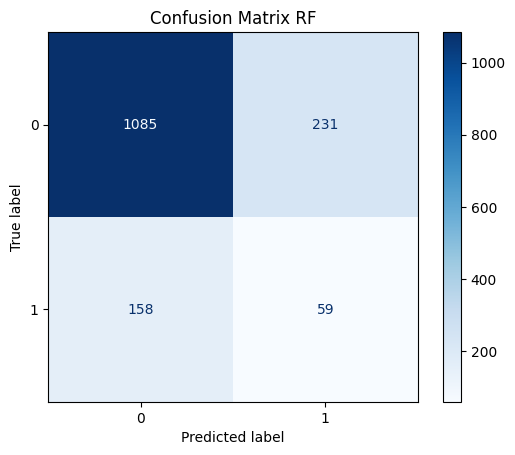

In [24]:
print('Random Forest Classifier')
print(classification_report(y_val, model_rf_clf.predict(X_val)));
plot_confusion_matrix(model_rf_clf, X_val, y_val, cmap=plt.cm.Blues)
plt.title('Confusion Matrix RF');

Extreme Gradient Boosting
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1316
           1       0.16      0.22      0.18       217

    accuracy                           0.73      1533
   macro avg       0.51      0.51      0.51      1533
weighted avg       0.76      0.73      0.74      1533



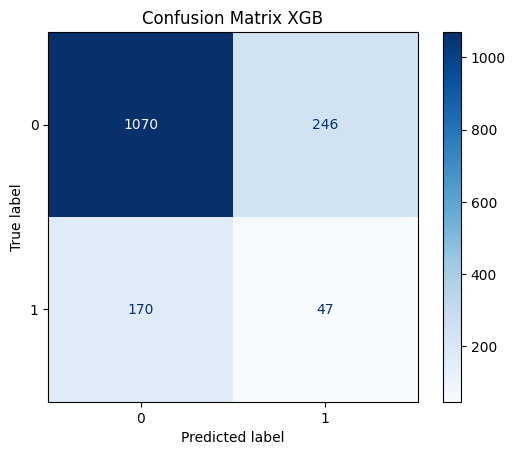

In [25]:
print('Extreme Gradient Boosting')
print(classification_report(y_val, model_xgb.predict(X_val)));
plot_confusion_matrix(model_xgb, X_val, y_val, cmap=plt.cm.Blues)
plt.title('Confusion Matrix XGB');

Between these two models, the accuracy seems to be better for the Random Forest Classifier, as well as the f1-score (harmonic mean of precision and recall). The recall on the other hand, is better for the XGBoost model. Let's see how those scores change once we implement some hyperparameter tuning focusing on the f1-score.

## Tuning / Communication

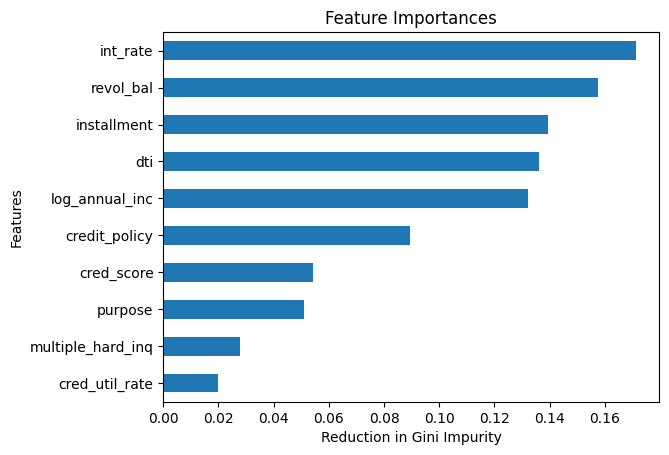

In [32]:
# Plot the top feature importances for Random Forest

importances = model_rf_clf.named_steps['randomforestclassifier'].feature_importances_
# features = model_rf_clf.named_steps['ordinalencoder'].get_feature_names()
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity')
plt.ylabel('Features')
plt.title('Feature Importances');

Text(0, 0.5, 'Feature')

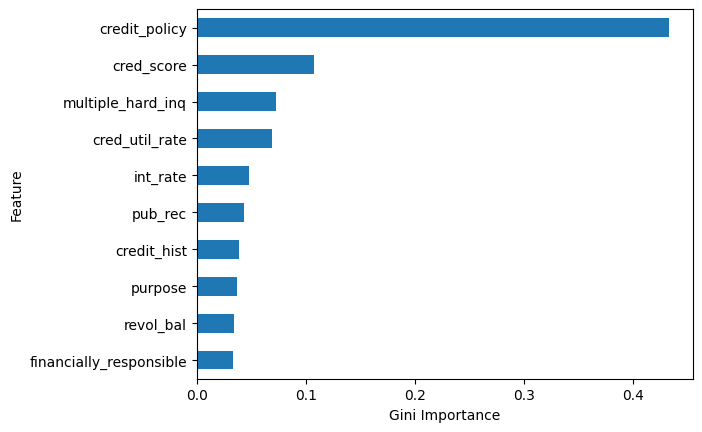

In [33]:
# Plot feature importances for XGboost

importances = model_xgb.named_steps['xgbclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp= pd.Series(data=importances, index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')

In [26]:
# Grid Search Random Forest to Maximize Recall

param_grid = {
    'randomforestclassifier__max_depth': range(3,30,3),
    'randomforestclassifier__n_estimators': range(25,125,25),
    'randomforestclassifier__min_samples_leaf': [1, 2, 4]
}


rf_gs = GridSearchCV(model_rf_clf,
             param_grid=param_grid,
             n_jobs=-1,
             cv=5,
             scoring='f1',
             verbose=1,
)

rf_gs.fit(X_train_bal, y_train_bal)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=['purpose'],
                                                       mapping=[{'col': 'purpose',
                                                                 'data_type': CategoricalDtype(categories=['all_other', 'credit_card', 'debt_consolidation',
                  'educational', 'home_improvement', 'major_purchase',
                  'small_business'],
, ordered=False),
                                                                 'mapping': all_other             1
debt_consolidation    2
credit_card           3
small_b...ss        4
educational           5
home_improvement      6
major_purchase        7
NaN                  -2
dtype: int64}])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(3, 30, 3),
                         'randomforestclassifier__min_samples_leaf': [1, 2, 4],
                         'randomforestclassifier__n_estimators': range(25, 125, 25)},
             scoring='f1', verbose=1)

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1316
           1       0.20      0.28      0.23       217

    accuracy                           0.74      1533
   macro avg       0.54      0.55      0.54      1533
weighted avg       0.78      0.74      0.76      1533



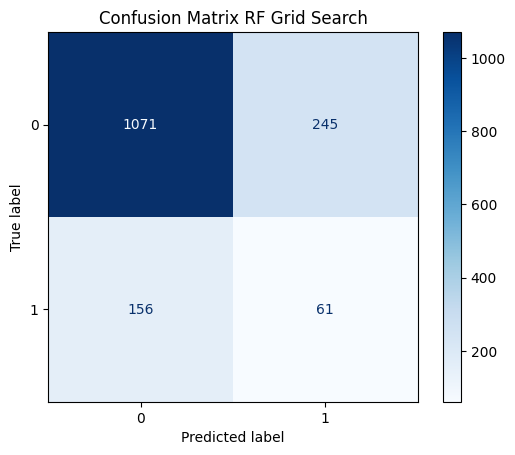

In [29]:
#Predict values based on new parameters
y_pred_rf_gs = rf_gs.predict(X_val)

# New Model Classification Report 
print(classification_report(y_val, y_pred_rf_gs));

# Random Foresr (Grid Search) Confusion matrix
plot_confusion_matrix(rf_gs, X_val, y_val, cmap=plt.cm.Blues)
plt.title('Confusion Matrix RF Grid Search');

In [30]:
rf_gs_best_score = rf_gs.best_score_
rf_gs_best_params = rf_gs.best_params_

print('Best score for `model`:', rf_gs_best_score)
print('Best params for `model`:', rf_gs_best_params)

Best score for `model`: 0.7795033167173095
Best params for `model`: {'randomforestclassifier__max_depth': 27, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 75}


In [27]:
# Grid Search XGBoost to Maximize Recall

params = {
    'xgbclassifier__max_depth': range (2, 30, 5),
    'xgbclassifier__n_estimators': range(100, 200, 50),
    'xgbclassifier__scale_pos_weight': [90, 93, 95]
}


xgb_gs = GridSearchCV(model_xgb,
             param_grid=params,
             n_jobs=-1,
             cv=5,
             scoring='f1',
             verbose=1,
             )

xgb_gs.fit(X_train_bal, y_train_bal)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=['purpose'],
                                                       mapping=[{'col': 'purpose',
                                                                 'data_type': CategoricalDtype(categories=['all_other', 'credit_card', 'debt_consolidation',
                  'educational', 'home_improvement', 'major_purchase',
                  'small_business'],
, ordered=False),
                                                                 'mapping': all_other             1
debt_consolidation    2
credit_card           3
small_b...
                                                      max_depth=6, max_leaves=0,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints='()',
                                                      n_estimators=100,
                                                      n_jobs=-1,
                                                      num_parallel_tree=1,
                                                      predictor='auto',
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__max_depth': range(2, 30, 5),
                         'xgbclassifier__n_estimators': range(100, 200, 50),
                         'xgbclassifier__scale_pos_weight': [90, 93, 95]},
             scoring='f1', verbose=1)

In [28]:
xgb_gs_best_score = xgb_gs.best_score_
xgb_gs_best_params = xgb_gs.best_params_

print('Best score for `model`:', xgb_gs_best_score)
print('Best params for `model`:', xgb_gs_best_params)

Best score for `model`: 0.7920708581608178
Best params for `model`: {'xgbclassifier__max_depth': 27, 'xgbclassifier__n_estimators': 150, 'xgbclassifier__scale_pos_weight': 93}


              precision    recall  f1-score   support

           0       0.87      0.68      0.77      1316
           1       0.17      0.39      0.23       217

    accuracy                           0.64      1533
   macro avg       0.52      0.53      0.50      1533
weighted avg       0.77      0.64      0.69      1533



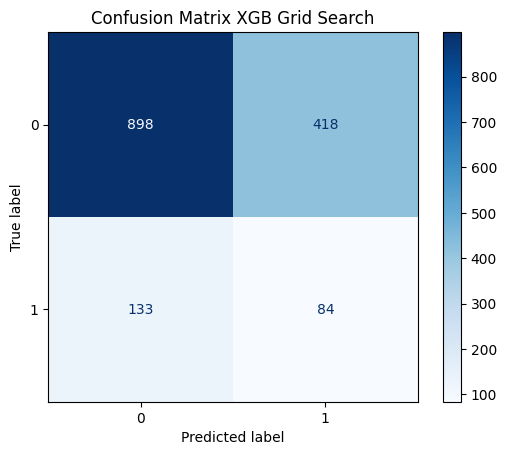

In [31]:
#Predict values based on new parameters
y_pred_xgb_gs = xgb_gs.predict(X_val)

# New Model Classification Report 
print(classification_report(y_val, y_pred_xgb_gs));

# Random Foresr (Grid Search) Confusion matrix
plot_confusion_matrix(xgb_gs, X_val, y_val, cmap=plt.cm.Blues)
plt.title('Confusion Matrix XGB Grid Search');

After tuning the hyperparameters, focusing on the f1-score, we ended up with less accuracy on both models, but higher f1-scores and recall when comparing with the scores we got before tuning. This time, the f1-score was the same for both models but the recall was better for the XGBoost model.

## Permutation Importances

In [35]:
perm_imp= permutation_importance(xgb_gs, X_val, y_val, random_state=42)

# Look at the dictionary
perm_imp

{'importances_mean': array([ 0.02593646, -0.00356814, -0.00445782, -0.00538636,  0.00062236,
        -0.03044888, -0.00206299, -0.00402881,  0.00882502, -0.00023044,
         0.00342823, -0.0182507 , -0.00080349]),
 'importances_std': array([0.00941871, 0.00587602, 0.01468134, 0.01254973, 0.00515653,
        0.01612661, 0.0175705 , 0.00156029, 0.01331194, 0.00095597,
        0.0019134 , 0.00984305, 0.00391343]),
 'importances': array([[ 1.22838123e-02,  1.79967542e-02,  3.31437193e-02,
          3.75288259e-02,  2.87291941e-02],
        [-5.68189427e-03, -1.21984955e-02,  5.63588011e-03,
         -8.24900484e-04, -4.77131437e-03],
        [-2.57278074e-02,  9.94421160e-03, -1.06860333e-02,
         -1.00203028e-02,  1.42008446e-02],
        [-1.47727700e-03, -1.32892246e-02,  4.71048972e-03,
         -2.56014011e-02,  8.72560881e-03],
        [ 6.45307488e-03, -4.87425196e-03, -5.73608126e-03,
          1.38033174e-03,  5.88874737e-03],
        [-4.75473069e-02, -1.11265647e-02, -4.645

In [36]:
data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')
df_perm

,imp_mean,imp_std
dti,-0.030449,0.016127
multiple_hard_inq,-0.018251,0.009843
installment,-0.005386,0.012550
int_rate,-0.004458,0.014681
pub_rec,-0.004029,0.001560
purpose,-0.003568,0.005876
revol_bal,-0.002063,0.017570
cred_util_rate,-0.000803,0.003913
financially_responsible,-0.000230,0.000956
log_annual_inc,0.000622,0.005157


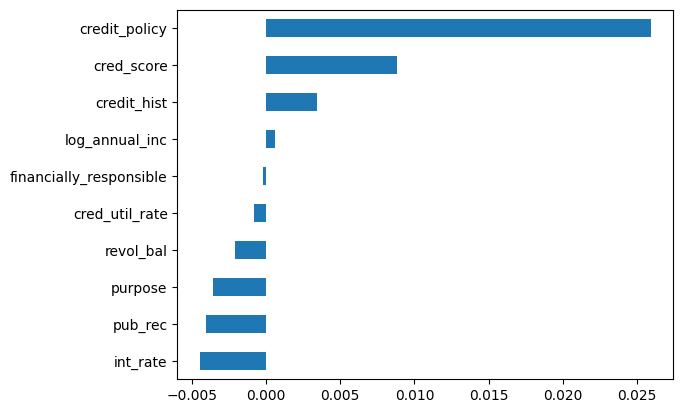

In [37]:
df_perm['imp_mean'].tail(10).plot(kind='barh');

We decided to implement permutation importances on the XGBoost Model and from the plot above we can deduct that <code>credit_policy</code> is the feature that might influence the target the most, along with <code>cred_score</code> and <code>log_annual_inc</code>.
